# Description

## Goal

Develop a unified community DA system for research and operations

## Partners

* NASA/GMAO
* NOAA/NWS
* NOAA/NESDISS
* NOAA/OAR
* NRL (Naval Research Lab)
* Oceanographer of the Navy
* US Air Force

## Components

* Models/Grids (reanalysis)
    * Atmosphere
    * Ocean
    * Land
    * Regional
    * Global
    * Toy models
* Observations
    * Past
    * Current
    * Future
* Solvers
    * Variational
    * EnKF
    * Hybrid
* In this context. OOPS refers to "Object Oriented Prediction System" a C++ implemented weather forecasting system developed by ECMWF

# Data Assimilation Issues

* Will existing systems be able to scale on future highly parallel machine architectures?
* Scientific/technical challenges to coupled DA
    * NGGPS (Next Generation Global Prediction System)
    * ESPC (Earth System Prediction Capability)


# JEDI Architecture

## Context surrounding JEDI

JEDI is the section with the pink boxes (pink represents DA processes) in the following figure. Figure is from a UCAR internal document titled "System Architecture for Operational Needs and Research Collaborations" and dated March 31, 2017.

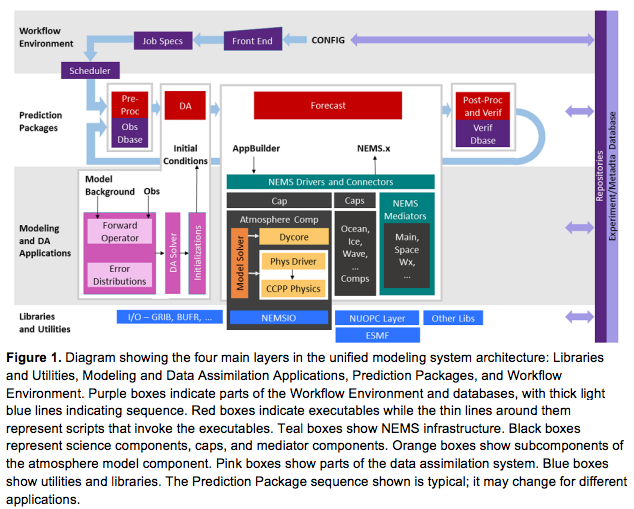

## JEDI Design

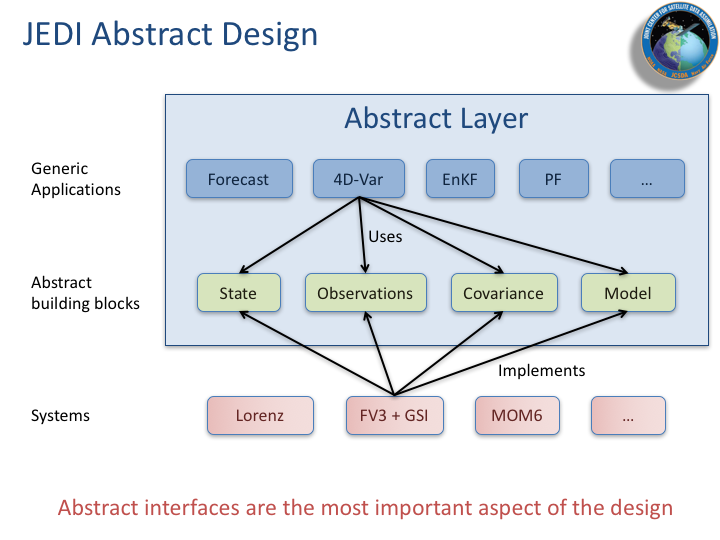

# Notes from 12/13/17 meeting with Yannick

Compute mismatch between forecast and observations
* Observation operator
* Model fields --> compute what observation would be
    * Wind, T are easy --> interpolate to location of obs
    * Satellite, Radar dBZ are complex
        * model quantities --> radar obs (simulated)

Two active items for obs operators
* Temperatures from radiosondes
* Radiance measurements from satellites
    * Satellite looks from top down
    * Surface interaction
    * Radiative transfer model, CRTM

Two steps for obs operators
* Model field --> interpolate to location that saellite is observing
    * Form profile: T, RH, etc.
* Call CRTM to get simulated radiance
* Compare simulated obs to actual obs

Mismatch between actual obs and simulate obs is express as a cost function
* DA is like a big optimization problem
* Do this 4 times a day (every 6 hours)
    * Sim obs, obs --> cost function --> adjust initial conditions for model --> simulate 6 more hours --> repeat

Two stage DA process
* First stage is model dependent
    * Specific grid
    * Interpolate step to get alignment between model and satellite locations
* Second stage is model independent
    * Common grid/locations
    * Cost function, adjust initial conditions

Collection of obs operators is also know as "forward ops"
* Everyone develops their own, we are trying to organize into a common set
* UFO --> Unified Forward Operators

Obs come in several formats
* Location, dae, time, which sensor, frequency, channels
* Want an API for access to these
    * Shared among different centers

100,000,000 obs operators
* Organize
* Process
* Etc.

Obs operators
* Meta data
* Access
* Two issues
    * Starndarize view into obs ops
    * Efficient API to access obs ops

# JEDI obs operators meeting 12/13/17

Update since last Code Sprint

Link GFS with UFO

Singularity, Docker

Verify code runs on disparate machines, different platforms
* Either new person of shared between Xin, Steve and Mark
* Trying to get funds for a new person

Locations linked into UFO

Radiances - checking mismatches

Anna
* Inputs to CRTM
    * Issues with effective radius, and getting it out of model
* Issue with profiles
    * Model doesn't go to TOA as represented in CRTM
    * Need to fill in upper section of profile
    * Preprocessing step that goes into CRTM

Bryan
* Geovals --> interpolated values (UFO)
    * T, RH, Ozone, SST, etc.
    * Array in geovals holds these
* Docker, FV3 build works using Intel compiler
    * Copy to "Thayer" and won't compile, could be new compiler is stricter than old version

Next steps
* Next meeting in January, after AMS
* Need to acquire, get access to, Intel compilers


# JEDI Interpolation meeting, 12/14/17

Jim Rosinski (Software Engineer)

Compile issues with CRTM

# JEDI Interpolations meeting 12/20/17

GitLFS
* Large file storage
* Compare with Google Drive, other cloud systems

Issues
* FV3 only compiles and runs on one machine with one compiler
* Tests
    * Need a short serial test, quick check for debug
    * Need a common initialization for all models

ecbuild
* Layer on top of CMake
* Macros

Latets CMake is version 3
* Free book online for version 2

Plan is to get rid of ecbuild and replace with CMake version 3
* New features in CMake version 3 cover what is being used from ecbuild

eckit
* C++ utilities
* Overlap with Boost
* Using this for testing framework
    * Look at Google, etc.
    * Mark will work on this



# Meeting with Yannick, 12/20/17

## Data Assimilation

Cost Function

$$ J(x_0) = \left\{\sum_{i=0}^{N} [H(x_i) - y_i]^T R^{-1} [H(x_i) -y_i]\right\} + (x_o - x_b)^T B^{-1} (x_o - X_b) $$

Where:
* $x_b$ is the background (model forecast)
* $x_o$ is the observation
* $H(x)$ is the observation operator (coversion of model output into observation data)
* $R$ is the observation covariance matrix (observation error)
* $B$ is the background covariance matrix (background error)
* $x_i$ is model state at time $t_i$
    * $x_i = M_{t_0 \rightarrow t_i}$

Trying to minimize the cost function (this is what GSI does).

UFO does the observation operator function ($H(x)$)

## Terminology (from JEDI requirements doc)
* Priors is same as background
* Innovation (new info, new obs), initial discrepancy of obs and background ($H(x_b) - y$)
* Unstructured grid, example is locations of ground stations
* Coupled DA
    * Atmosphere
    * Ocean
    * Sea Ice
    * Land surface
    
    * Can do cost function analysis on each of the above
    * Coupled DA is simultaneously processing all or subset of above
* One-way coupling
    * Sea $\rightarrow$ Atmos
    * Atmos $\rightarrow$ Sea
    * Typically not that useful, but used for wind effects on water waves (i.e., on a naturally one-way process)
* Two-way coupling
    * Surface $\leftrightarrow$ Atmos
* Observation thinning
    * Too many observations, keep an arbitrary selection, e.g. every 100th
    * Lots of obs close to each other
        * Not independent samples
        * Hard to deal with correlations, come up with a representative value
* Superobbing
    * Many spatially local obs, average together
        * Difficult to evaluate error
    * Popular in the US, not so much in Europe
    * Keeping a subset of obs (thinning) is typically easier to manage
* Localization
    * EnKF (Ensemble Kalman Filter) technique
    * Ensemble forecast, look for linear combination of members of ensemble
        * Millions of obs, too big computationally
    * Look for linear combination on local spatial scale
        * Reduce size of set, computable
* Inflation
    * Related to Localization
    * EnKF
    * After repeating DA process, ensembles tend to look more alike (collapse)
    * Inflation is a process to inject differences into ensembles (opposite of collapse)
* Out-of-core computation
    * Fancy term for swapping memory
    * Examples given in the JEDI requirements document is not typical
* CGAL
    * "Computational Geometry Algorithms Library"
    * C++ library
    * Geometric algorithms
        * Veronoi diagrams
        * Triangulation
        * Surface and volume mesh generation
        * Geometry processing
        * Etc.
* Boost
    * C++ library
    * Utilities
    * boost.org
    * In our case, used for testing framework
* TensorFlow
    * Python library
    * Machine learning
    * Big data
    * Could be used as data structure for obs.
        * But, Fortran to Python is awkward
        * Mabye go to underlying C++, but only if clean C++ API
* BUFR
    * WMO format for exchanging obs
        * Old, before internet
    * All satellite data arrives in this format
    * Different format for each obs

## Test stragey
* We want to use all types of tests
    * Unit
    * Integration
    * System
    * Acceptance
* The usage of "unit test" in the requirements doc generally refers to all types of testing

## UFO
* UFO is $H(x)$ operator in cost function
    * $x$ is state of atmosphere, model fields
    * Each lab has their own way of representing $x$
    
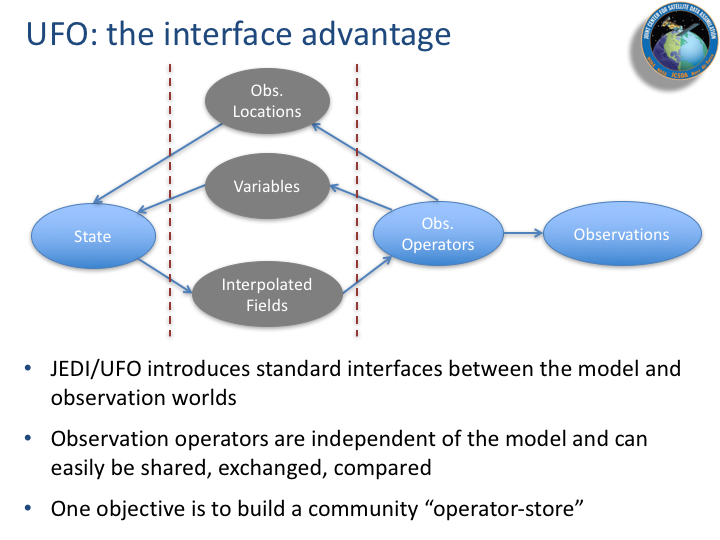

   ### Notes on above diagram
    * Observation Operators
        * CRTM
        * Interpolation to standard vertical levels is done here for now
    * Interpolated fields
        * Geovals
        * Abstracted
        * Profile (p, T, RH, etc.)
    * Observations
        * Satellite, sondes, radar, etc.
        * Metadata
            * Channels
            * Frequency
            * Etc.

## DA Flow
* DA process has two steps
    1. Interpolation
    1. Scientific application

    ### Example
    
    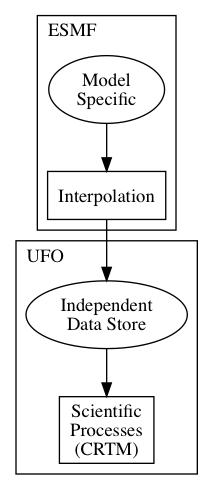

        * ESMF is interpolation step
            * EMSF - Earth System Modeling Framework
            * Large system
            * Fortran
            * Monolithic structure
                * Makes it difficult to use
            * Be nice to break this up into modules
        * UFO is scientific application step


# Meeting with Clara Draper, 12/20/17

* BUFR to netcdf conversion
    * Jeff Whitaker
    * Python code
        * JEDI_conv_bufr2nc_2D.py
            * Sample input BUFR: prebufr.gdas.2016030406
        * JEDI_amsu_bufr2nc.v8.py
            * Sample input BUFR: 1bamua.gdas.2016030406
    * Python module, py-ncepbufr
        * Call Fortran library routines for accessing BUFR files
        * Stored on GitHub
            * jswhit/py-ncepbufr
* ASMU --> Advanced Sensing Microwave Unit
* Conventionals --> sounding values (p, T, RH, etc.)
* BUFR
    * Self describing binary file
    * Query tables to find variables
        * Record --> messages --> observations
* Currently, GSI reads in data directly from BUFR files
* Want to have GSI read in abstracted observational data with common API
* The python conversion scripts are prototypes of the abstracted observational data
    * Clara also created netcdf reader for GSI
    * Currently have one netcdf file for each variable
        * Want to move to one file for each instrument/obs set ("Observation Type")
    * BUFR --> netcdf --> GSI --> GSI output
        * GSI output produced from netcdf (new) flow should match (bit compatible) with current GSI output
    * Python scripts are probably heavier weight than what is necessary
    * Scott Gregory can help with questions
* Theia --> server where examples are stored
* Clara will be out next week and at AMS


# Meeting with Yannick, 12/22/17

## IODA
* Interface for Observational Data Access
* Common view API
* Use cases
    * Long term archive of obs data
        * Research use
        * Large capacity, permanent storage (tape?)
        * Do not require fast access
    * Data for last 6 hours on store
        * Fast access
        * Operational mode
        * Research/Development testing
    * In-memory data structure
        * HPC system
        * Distributed across multiple processes
        * Fast access
    * Plotting, statistics
        * Desktop/Laptop
        * Read from store into memory
        * Small process so can do with desktop, laptop
* Fortran, C++, Python
* Incoming data is very diverse
    * Aircraft
    * Satellite
    * Radar
    * Etc.
* Need generic format, UFO is an example of this
* GitHub repository --> UCAR/ioda
* This is what I will own eventually
* Take a look
    * Uses netcdf from bufr2nc

## ODB API
* ODB --> Observational DataBase
* ECMWF developed
* Open source
* If we develop something new, it has to be better than ODB API
    * Either ODB is a candidate for our solution
    * Or it is a model of what we want
* Core is written in C, C++
* API for Fortran, C++ and Python
* netcdf
* ~300,000 lines of code
* Good design and implementation
    * Been in production for a while
    * Uses a variant of SQL
    * ODB1
        * Fully distributed (HPC)
        * Efficient
        * Not open source
    * ODB2
        * Fully distributed
        * Not as efficient as ODB1
        * Open source

## TensorFlow
* Python
* Machine learning
* Optimization features that may be applicable to the DA cost function minimization problem
* People will want to access data through TensorFlow
* Learn how access would work
* Learn basic concepts of TensorFlow

## UFO
* Look at
    * ufo_radiance_mod.F90
    * ufo_radiosonde_mod.F90
    
    * Look at C++ wrappers for these too
    * These are examples of how the access to observational data is envisioned

## Books for group
* CMake
* "Object Oriented Software Construction"
* Tom buy a few copies for the group

# JEDI Interpolations meeting, 1/17/18
* Trying to integrate FV3 with JEDI
* Got FV3 to compile and have tests running
    * Lots of test failures
    * Dot product fails
        * Maybe including halo and double counting
    * FV3 must run in parallel (at least 6 processes)
        * Could try with no halo, but that will mess up the model
    * Working on nasa-discover-\* branches in code
* Interpolations, UFO
    * QG
    * Lawrence
* Events
    * OOPS training
        * 1 week
        * For devlopers
        * Cover relevant topics in C++
        * Cover object oriented design
    * Code sprints
        * Potential topics
            * Interpolations
            * Obs processes (QC, R matrix)
            * Obs bias correction
            * Testing
            * CRTM
                * Jacobians
            * B Matrix
            * Ocean
            * ???
* Dan Holdaway is visiting
    * Mini code sprint to get FV3 working with UFO
* Expand meeting audience in future to cover more models